In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_excel('/Users/heyminhminh/Downloads/Data_Set.xlsx')
data.head()

,id,addr_state,annual_inc,emp_length,emp_title,home_ownership,installment,loan_amnt,purpose,term,...,num_il_tl,num_op_rev_tl,num_tl_90g_dpd_24m,num_tl_op_past_12m,open_acc,percent_bc_gt_75,pub_rec_bankruptcies,total_acc,total_bal_ex_mort,loan_status
0,802173,CA,72000.0,3 years,CA. Dept. Of Corrections,MORTGAGE,395.66,12000,debt_consolidation,36 months,...,NaN,NaN,NaN,NaN,16,NaN,0,23,NaN,Fully Paid
1,14518910,TX,97500.0,1 year,Curriculum & Implementation Manager,RENT,966.47,35000,debt_consolidation,60 months,...,2.0,12.0,0.0,1.0,13,87.5,0,24,84227.0,Fully Paid
2,54333324,NY,120000.0,1 year,Senior manager,RENT,806.57,25000,credit_card,36 months,...,2.0,7.0,0.0,1.0,8,100.0,0,16,39124.0,Fully Paid
3,62247022,CA,130000.0,10+ years,Border Patrol Agent,RENT,846.17,25225,debt_consolidation,36 months,...,9.0,3.0,0.0,2.0,8,50.0,0,24,123331.0,Fully Paid
4,71986114,TX,58296.0,10+ years,Account Manager,MORTGAGE,41.79,1200,other,36 months,...,7.0,6.0,0.0,0.0,9,100.0,0,17,51794.0,Fully Paid


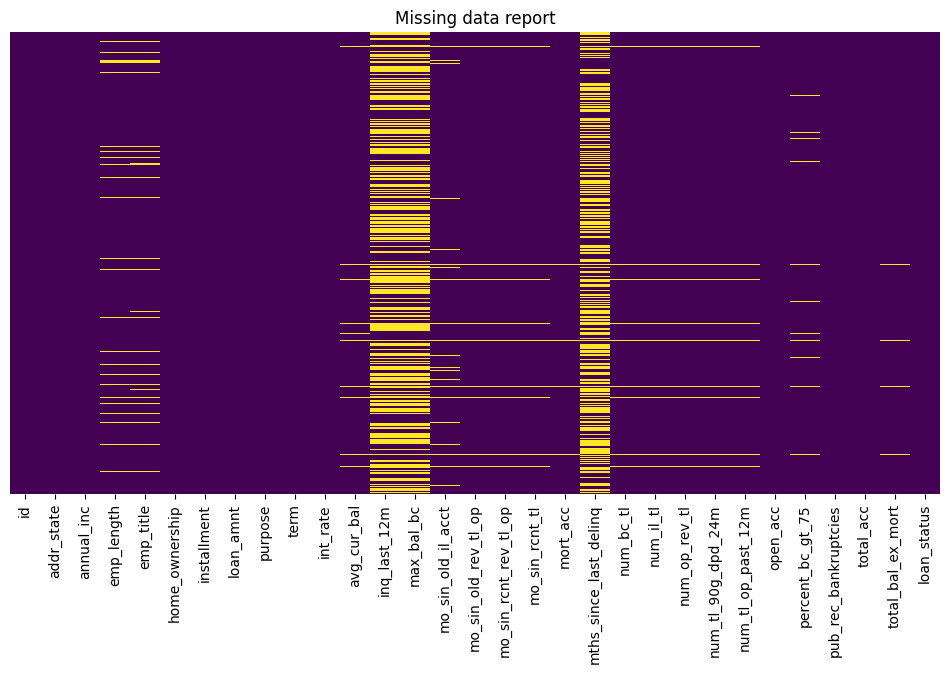

In [3]:
#use seabonn visual the missing data 
#We notice that there are some variables with many missing values (e.g. inq_last_12m, max_bal_12m)
fig, ax1 = plt.subplots(figsize=(12,6))
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis').set(title='Missing data report')
plt.show()

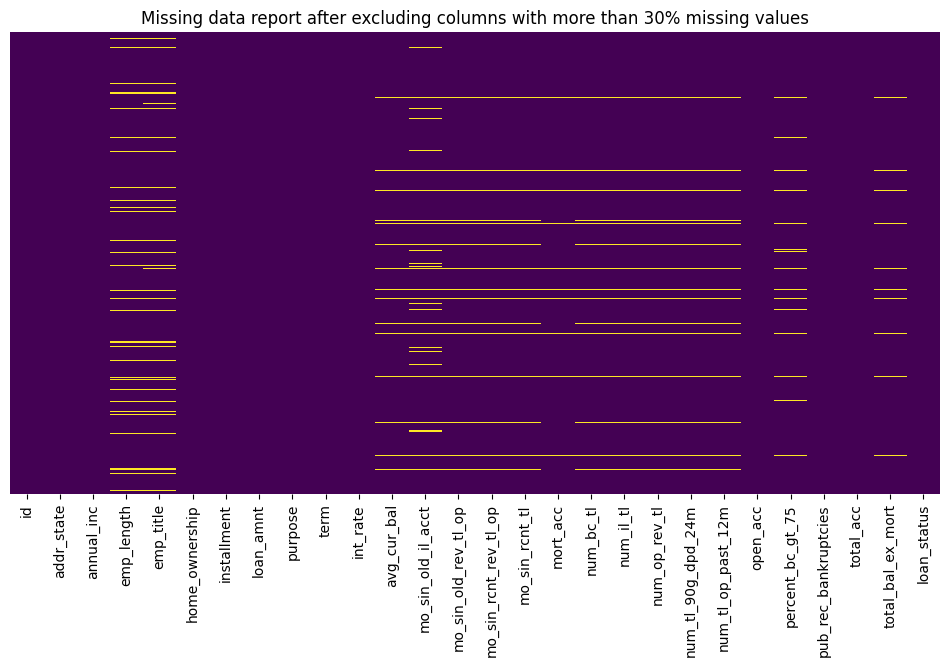

In [4]:
# With min_count we calculate the number of missing records that is acceptable (30%) and with dropna() 
# we then drop those columns. The resulting datatset has 4 columns less as a result of this process. 
perc = 20.0
min_count =  int(((100-perc)/100)*data.shape[0] + 1)
data=data.dropna(axis= 'columns',thresh=min_count)
fig, ax1 = plt.subplots(figsize=(12,6))
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis').set(title='Missing data report after excluding columns with more than 30% missing values')
plt.show()

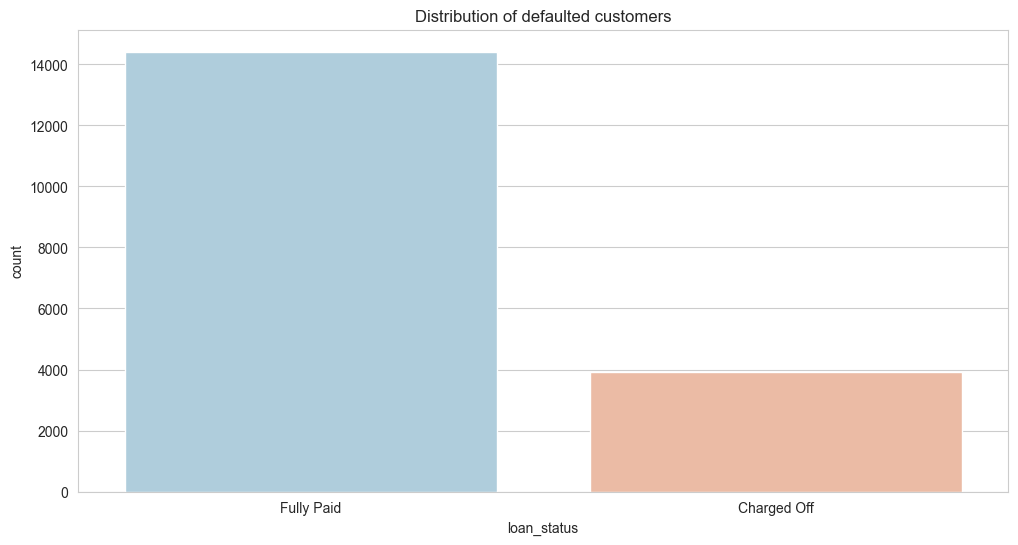

In [5]:
#EDA
sns.set_style('whitegrid')
fig, ax1 = plt.subplots(figsize=(12,6))
sns.countplot(x='loan_status',data=data,palette='RdBu_r').set(title='Distribution of defaulted customers')
plt.show()

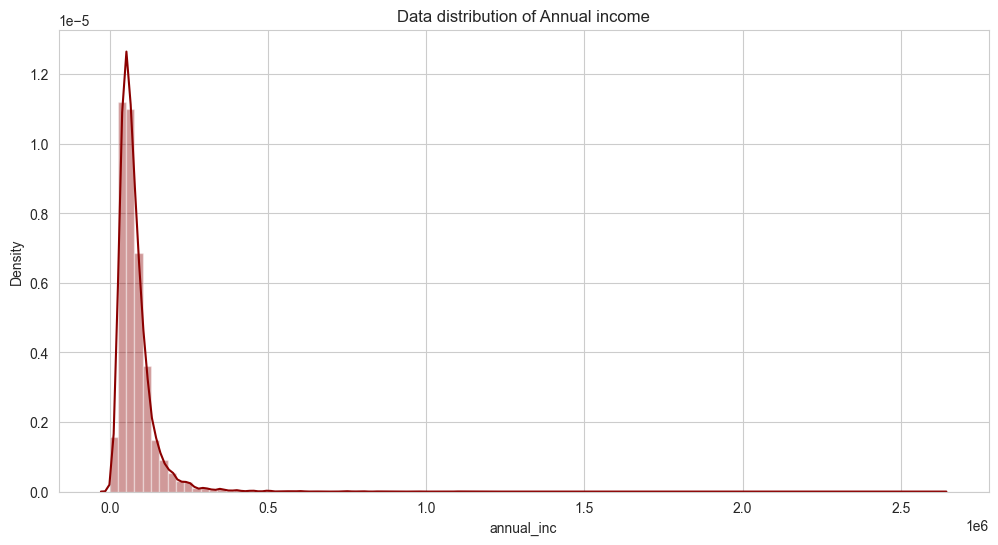

In [16]:
fig, ax1 = plt.subplots(figsize=(12,6))
sns.distplot(data['annual_inc'].dropna(),kde=True,color='darkred',bins=100).set(title='Data distribution of Annual income')
plt.show()

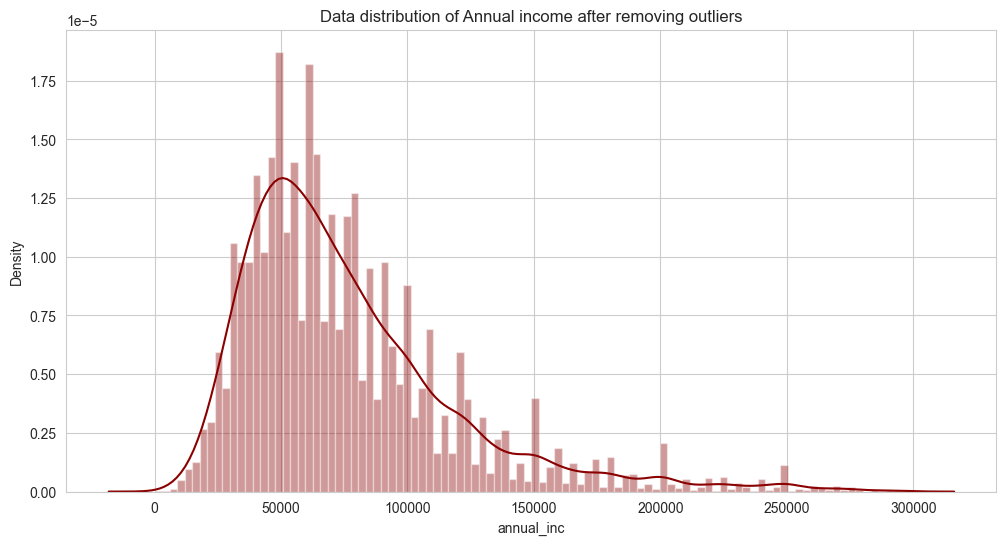

In [17]:
data=data[data['annual_inc']<300000]
fig, ax1 = plt.subplots(figsize=(12,6))
sns.distplot(data['annual_inc'].dropna(),kde=True,color='darkred',bins=100).set(title='Data distribution of Annual income after removing outliers')
plt.show()

In [21]:
#Preparation of the data for the graph:
df_grouped=data.groupby([pd.cut(data["annual_inc"], np.arange(0, 1000.0+100000, 10000)),'loan_status']).size()
df_grouped1=df_grouped.groupby(level=0).apply(lambda x: x/x.sum() * 100).unstack(level='loan_status').reset_index()
df_grouped=df_grouped.groupby(level=0).apply(lambda x: x).unstack(level='loan_status').reset_index()
df_grouped['Total']=df_grouped['Charged Off'] + df_grouped['Fully Paid']

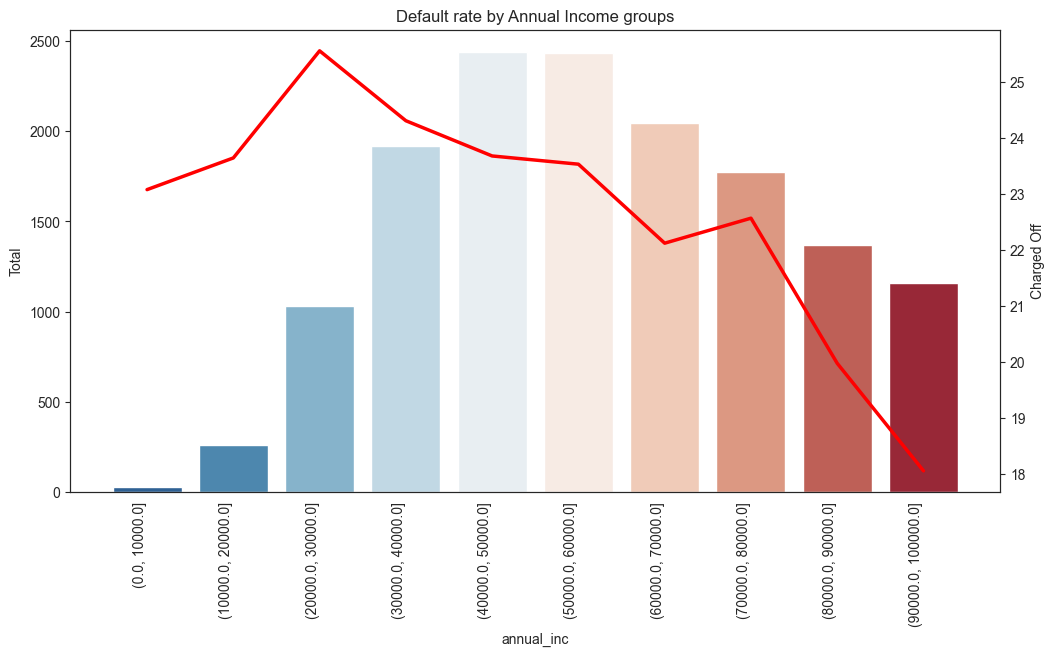

In [22]:
#Graph:
sns.set_style('white')
df_grouped=df_grouped.dropna()
df_grouped1=df_grouped1.dropna()
fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(data=df_grouped, x="annual_inc", y="Total", ax=ax1,palette='RdBu_r')
ax2 = ax1.twinx()
sns.lineplot(data=df_grouped1, x=df_grouped1["annual_inc"].astype(str), y="Charged Off",ax=ax2, color='r', linewidth=2.5).set(title='Default rate by Annual Income groups')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, horizontalalignment='right')
plt.show()

In [23]:
#Preparation of data for the graph:
df_grouped = data.groupby(['pub_rec_bankruptcies','loan_status']).size()
df_grouped1=df_grouped.groupby(level=0).apply(lambda x: x/x.sum() * 100).unstack(level='loan_status').reset_index()
df_grouped=df_grouped.groupby(level=0).apply(lambda x: x).unstack(level='loan_status').reset_index()
df_grouped['Total']=df_grouped['Charged Off'] + df_grouped['Fully Paid']

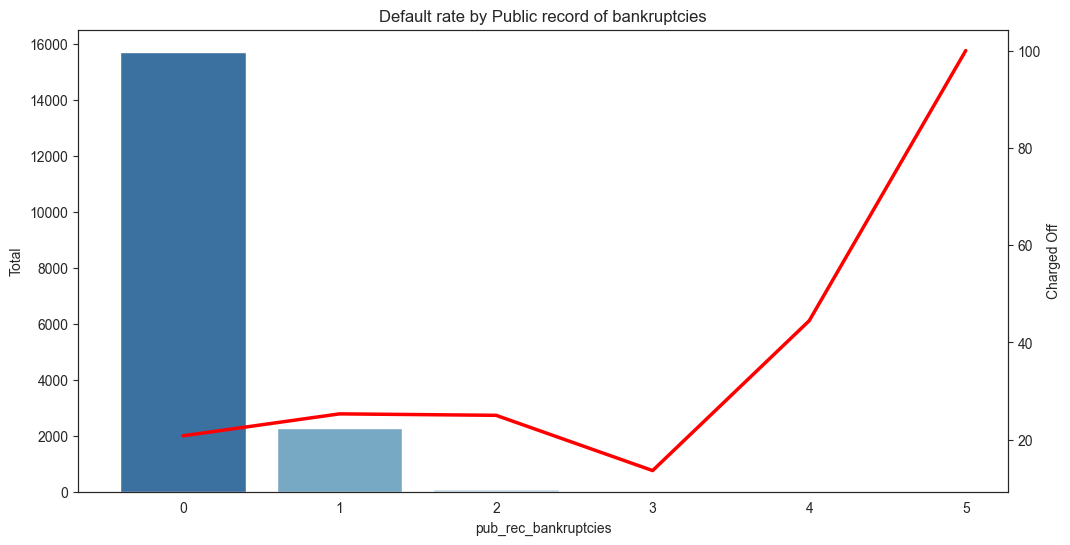

In [24]:
#Graph:
sns.set_style('white')
fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(data=df_grouped, x="pub_rec_bankruptcies", y="Total", ax=ax1,palette='RdBu_r')
ax2 = ax1.twinx()
sns.lineplot(data=df_grouped1, x="pub_rec_bankruptcies", y="Charged Off",ax=ax2, color='r', linewidth=2.5).set(title='Default rate by Public record of bankruptcies')
plt.show()

In [6]:
#Preparation of data for the graph for employment _length
df_grouped = data.groupby(['emp_length','loan_status']).size()
df_grouped1=df_grouped.groupby(level=0).apply(lambda x: x/x.sum() * 100).unstack(level='loan_status').reset_index()
df_grouped=df_grouped.groupby(level=0).apply(lambda x: x).unstack(level='loan_status').reset_index()
df_grouped['Total']=df_grouped['Charged Off'] + df_grouped['Fully Paid']
df_grouped['emp_length'] = pd.Categorical(df_grouped['emp_length'],
                                   categories=['< 1 year','1 year','2 years',
                                              '3 years','4 years','5 years',
                                              '6 years','7 years','8 years',
                                              '9 years','10+ years'],
                                   ordered=True)
df_grouped1['emp_length'] = pd.Categorical(df_grouped1['emp_length'],
                                   categories=['< 1 year','1 year','2 years',
                                              '3 years','4 years','5 years',
                                              '6 years','7 years','8 years',
                                              '9 years','10+ years'],
                                   ordered=True)

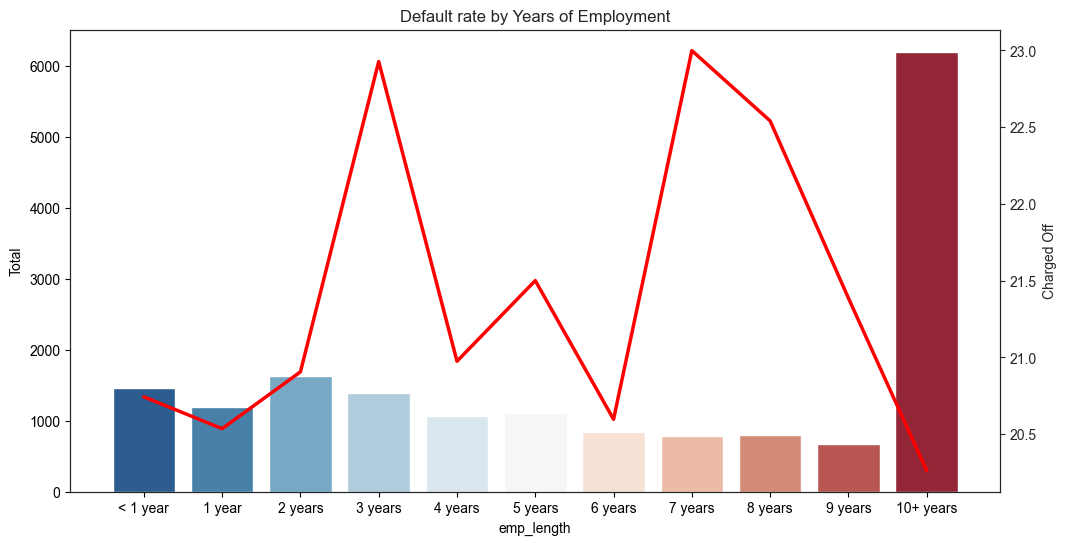

In [7]:
fig, ax1 = plt.subplots(figsize=(12,6))
sns.set_style('white')
sns.barplot(data=df_grouped, x="emp_length", y="Total", ax=ax1, palette='RdBu_r')
ax2 = ax1.twinx()
sns.lineplot(data=df_grouped1, x="emp_length", y="Charged Off",ax=ax2, color='r', linewidth=2.5).set(title='Default rate by Years of Employment')
plt.show()

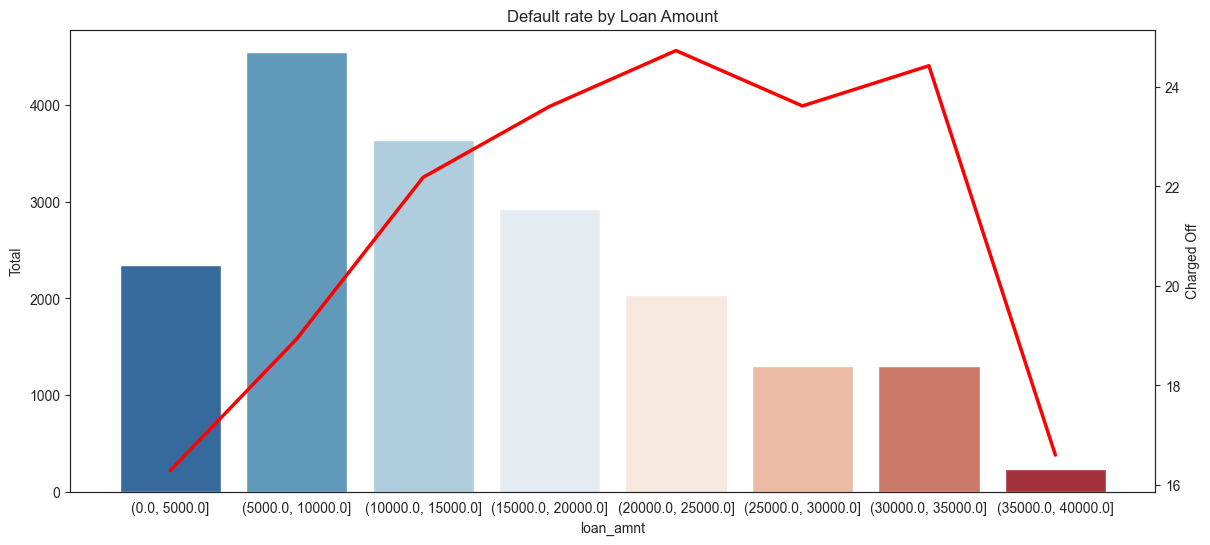

In [8]:
#loant amount graph
df_grouped=data.groupby([pd.cut(data["loan_amnt"], np.arange(0, 1000.0+40000, 5000)),'loan_status']).size()
df_grouped1=df_grouped.groupby(level=0).apply(lambda x: x/x.sum() * 100).unstack(level='loan_status').reset_index()
df_grouped=df_grouped.groupby(level=0).apply(lambda x: x).unstack(level='loan_status').reset_index()
df_grouped['Total']=df_grouped['Charged Off'] + df_grouped['Fully Paid']
df_grouped=df_grouped.dropna()
df_grouped1=df_grouped1.dropna()
fig, ax1 = plt.subplots(figsize=(14,6))
sns.set_style('white')
sns.barplot(data=df_grouped, x="loan_amnt", y="Total", ax=ax1, palette='RdBu_r')
ax2 = ax1.twinx()
sns.lineplot(data=df_grouped1, x=df_grouped1["loan_amnt"].astype(str), y="Charged Off",ax=ax2, color='r', linewidth=2.5).set(title='Default rate by Loan Amount')
plt.show()

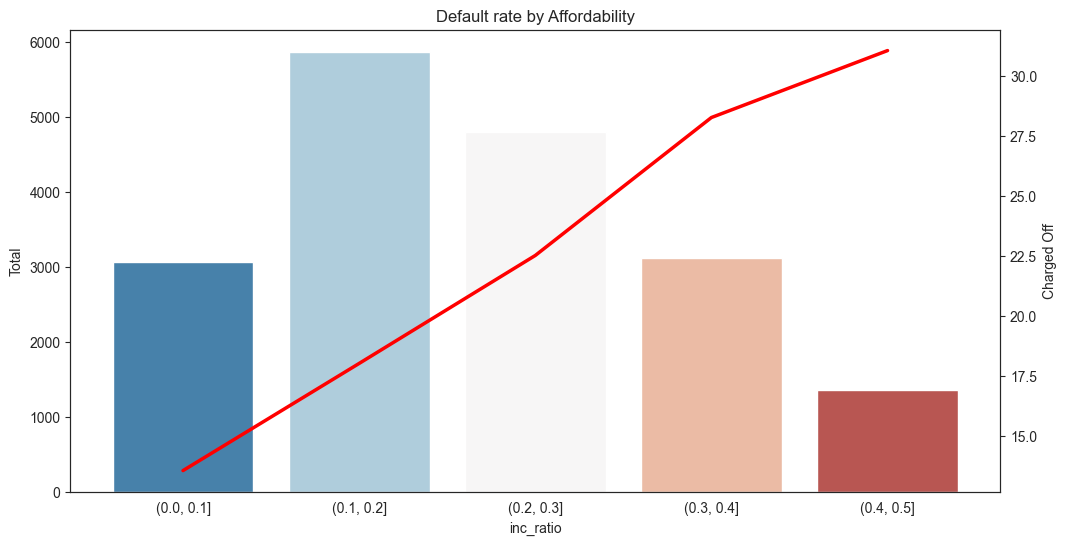

In [9]:
data['inc_ratio'] = data['loan_amnt']/data['annual_inc']
df_grouped=data.groupby([pd.cut(data["inc_ratio"], np.arange(0, 0.1+0.5, 0.1)),'loan_status']).size()
df_grouped1=df_grouped.groupby(level=0).apply(lambda x: x/x.sum() * 100).unstack(level='loan_status').reset_index()
df_grouped=df_grouped.groupby(level=0).apply(lambda x: x).unstack(level='loan_status').reset_index()
df_grouped['Total']=df_grouped['Charged Off'] + df_grouped['Fully Paid']
df_grouped=df_grouped.dropna()
df_grouped1=df_grouped1.dropna()
fig, ax1 = plt.subplots(figsize=(12,6))
sns.set_style('white')
sns.barplot(data=df_grouped, x="inc_ratio", y="Total", ax=ax1,palette='RdBu_r')
ax2 = ax1.twinx()
sns.lineplot(data=df_grouped1, x=df_grouped1["inc_ratio"].astype(str), y="Charged Off",ax=ax2, color='r', linewidth=2.5).set(title='Default rate by Affordability')
plt.show()

In [10]:
#Building a Logistic Regression model
data['status'] = np.where(data['loan_status'] =='Charged Off', 1, 0)
home_ownership = pd.get_dummies(data['home_ownership'],drop_first=True)
train=data[['status','inc_ratio','pub_rec_bankruptcies','num_tl_op_past_12m','open_acc']].fillna(0) 
train = pd.concat([train,home_ownership],axis=1)
X_train, X_test, y_train, y_test = train_test_split(train.drop('status',axis=1), 
                                                    train['status'], test_size=0.30,  stratify=train['status'],
                                                    random_state=101)
logmodel = LogisticRegression(max_iter = 500)
logmodel.fit(X_train,y_train)

LogisticRegression(max_iter=500)

In [11]:
predictions = logmodel.predict(X_test)
print(classification_report(y_test,predictions))


              precision    recall  f1-score   support

           0       0.79      1.00      0.88      4326
           1       0.52      0.01      0.02      1172

    accuracy                           0.79      5498
   macro avg       0.65      0.50      0.45      5498
weighted avg       0.73      0.79      0.70      5498



In [12]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predictions)
print(confusion_matrix)

[[4314   12]
 [1159   13]]


In [13]:
# If we just want to print out accuracy directly we can use: 
print("Accuracy of the Logistic Regression model is",round(accuracy_score(y_test,predictions),2))

Accuracy of the Logistic Regression model is 0.79


In [14]:
#Building a Random Forest model

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rfmodel = RandomForestClassifier(max_depth= 8, n_estimators=100, random_state=42)
rfmodel.fit(X_train,y_train)

RandomForestClassifier(max_depth=8, random_state=42)

In [15]:
#Get the predictions from the Random Forest Model
predictions_rf = rfmodel.predict(X_test)
# Print out the classification report
print(classification_report(y_test,predictions_rf))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      4326
           1       0.56      0.02      0.03      1172

    accuracy                           0.79      5498
   macro avg       0.68      0.51      0.46      5498
weighted avg       0.74      0.79      0.70      5498



In [16]:
#Print the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, predictions_rf)
print(confusion_matrix)

[[4312   14]
 [1154   18]]


In [17]:
print("Accuracy of the Random Forest Model is",
      round(accuracy_score(y_test,predictions_rf),2))

Accuracy of the Random Forest Model is 0.79


In [18]:
importances = rfmodel.feature_importances_

sorted_indices = np.argsort(importances)[::-1]
for i in sorted_indices:
    print("{0:25} {1:6}".format(X_train.columns[i],round(importances[i],4)))

inc_ratio                 0.5002
open_acc                  0.1956
num_tl_op_past_12m        0.1743
pub_rec_bankruptcies      0.0492
RENT                      0.0356
MORTGAGE                  0.0345
OWN                       0.0107


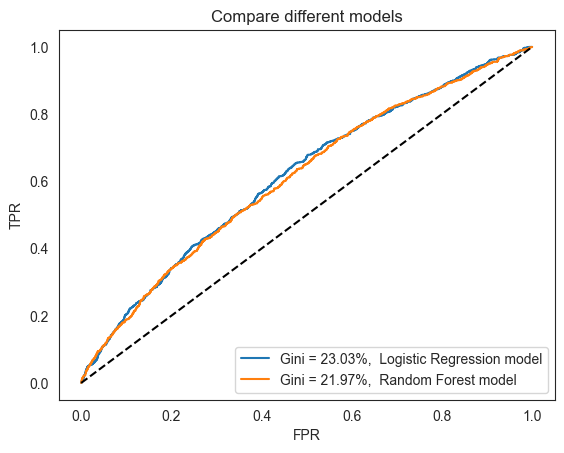

In [24]:
#Gini coefficient
# Function to calculate and plot gini curve
def plot_roc(y_true, scores_names):
    '''
    plot ROC curves for the specified model scores

            Parameters:
                    y_true (num): Target variable 
                    scores_names (tuple): a tuple of model predictions and model label
    '''
    
    for score, label in scores_names:
        fpr, tpr, _ = roc_curve(y_true, y_score=score, drop_intermediate=False)
        AUC = roc_auc_score(y_true, score)
        gini = 2 * AUC - 1
        label = 'Gini = {:.2%},  {}'.format(gini, label)
        plt.plot(fpr, tpr, label=label)
    plt.plot([0,1],[0,1], '--k')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right")
    plt.show();
# Calculate probability outcome to feed into Gini function
log_proba = logmodel.predict_proba(X_test)[:, 1]
rf_proba = rfmodel.predict_proba(X_test)[:, 1]
# Compare all models on March 21' full apps sample

plt.title('Compare different models')
plot_roc(y_test, [(log_proba, 'Logistic Regression model'), (rf_proba, 'Random Forest model')])
